## Multi-modal RAG

Many documents contain a mixture of content types, including `text, tables, and images`. 

Semi-structured data can be challenging for conventional RAG for at least two reasons: 

* Text splitting may break up tables, corrupting the data in retrieval
* Embedding tables may pose challenges for semantic similarity search


`KeyPoints:` 

* Use a multimodal LLM (such as [GPT4-V](https://openai.com/research/gpt-4v-system-card), [Ollama](https://ollama.com/library/llama3.2-vision)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 
* [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw tables, text, (optionally) images along with their summaries for retrieval.

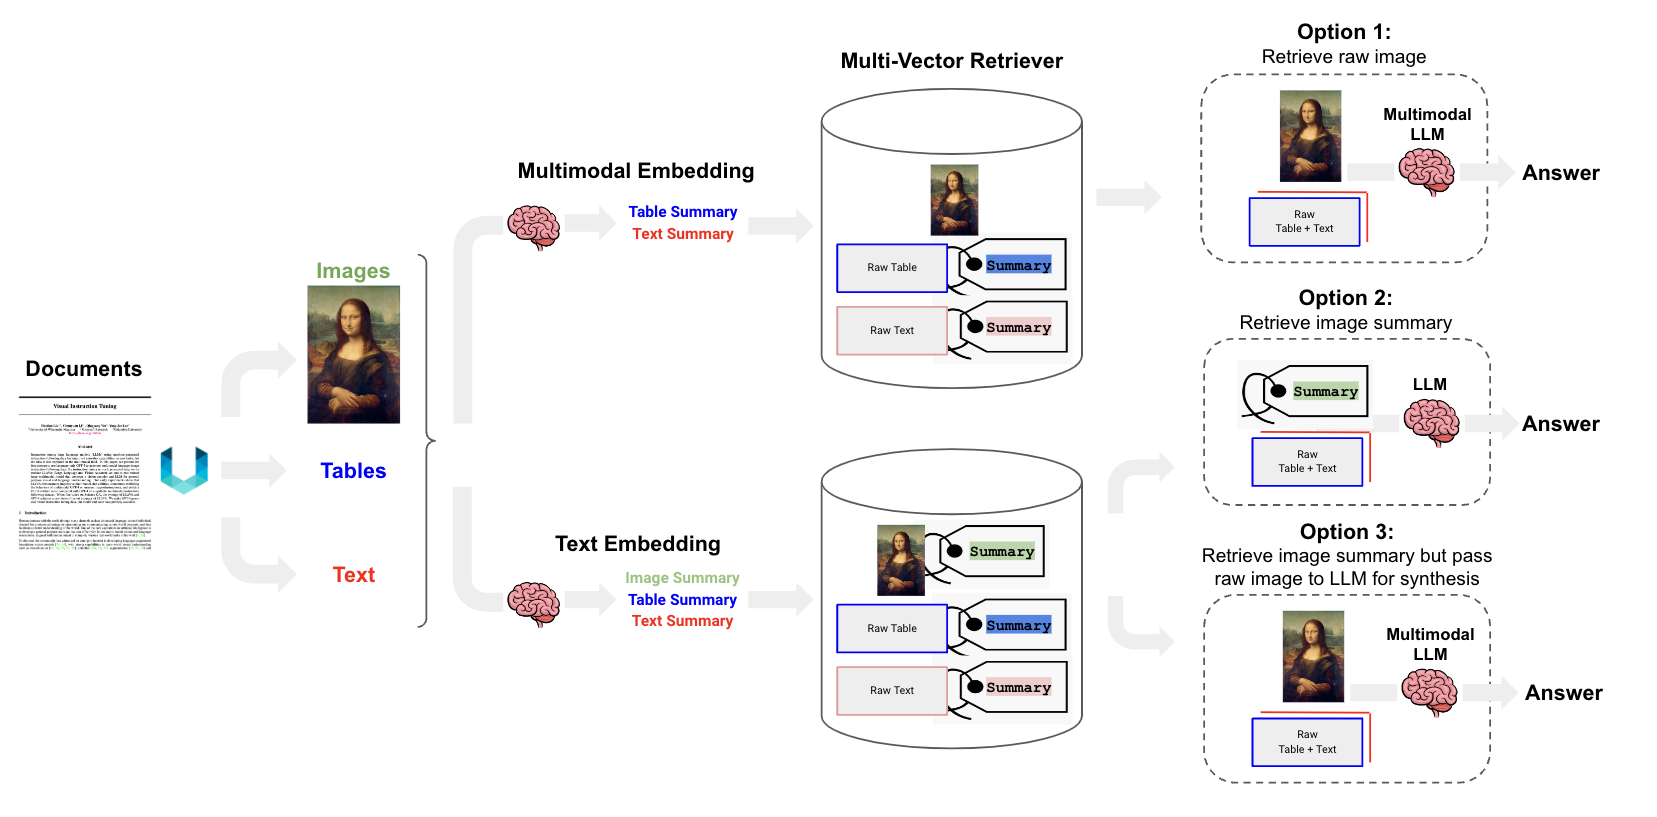



Paper : `Attention Is All You Need`

In [127]:
!wget "https://arxiv.org/pdf/1706.03762"

--2024-12-29 22:18:07--  https://arxiv.org/pdf/1706.03762
Resolving arxiv.org (arxiv.org)... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


151.101.67.42, 151.101.3.42, 151.101.195.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.67.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2215244 (2.1M) [application/pdf]
Saving to: ‘1706.03762’

1706.03762          100%[===================>]   2.11M  --.-KB/s    in 0.1s    

2024-12-29 22:18:07 (18.2 MB/s) - ‘1706.03762’ saved [2215244/2215244]



In [85]:
! pip install langchain langchain-chroma "unstructured[all-docs]" pydantic lxml

## Data Loading

### Partition PDF tables, text, and images
  
* Paper: https://arxiv.org/pdf/1706.03762.pdf
* Use [Unstructured](https://unstructured-io.github.io/unstructured/) to partition elements

In [129]:
path = "RAG/"

In [132]:
from typing import Any
from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "1706.03762",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [133]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 20,
 "<class 'unstructured.documents.elements.Table'>": 4}

In [134]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

4
20


## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

Summaries are used to retrieve raw tables and / or raw chunks of text.

### Text and Table summaries

In [135]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

### Load Embedding Model and LLM

In [136]:
from llm_call import *
chat_llm=get_llm()
embedding=get_embedding_model()

In [137]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = chat_llm
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [138]:
# Apply to text
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [139]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### Images Summary

In [141]:
import ollama
import os

 # Prompt
prompt = """You are an assistant tasked with summarizing images for retrieval.
                Remember these images could potentially contain graphs, charts or 
                tables also.
                These summaries will be embedded and used to retrieve the raw image 
                for question answering.
                Give a detailed summary of the image that is well optimized for 
                retrieval.
                Do not add additional words like Summary: etc.
             """

class ImageSummary():

    def __init__(self):
        # self.client = chat_llm
        pass

    def __call__(self, url):
        try:
            summary = ollama.chat(
                        model='llama3.2-vision',
                        messages=[{
                            'role': 'user',
                            'content':prompt,
                            'images': [url],
                        }] 
                    )      

            # print(f"Summary of the image: {summary['message']['content']}")
            return summary['message']['content']
        except Exception as e:
            print(e)

In [142]:
import base64
import os
from IPython.display import Image

# create a function to encode images
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """
    # Store base64 encoded images
    img_base64_list = []
    # Store image summaries
    image_summaries = []
    
   
    image_summary = ImageSummary()
    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summary(img_path))
    return img_base64_list, image_summaries

# Image summaries
IMG_PATH = './Images'
imgs_base64, image_summaries = generate_img_summaries(IMG_PATH) 

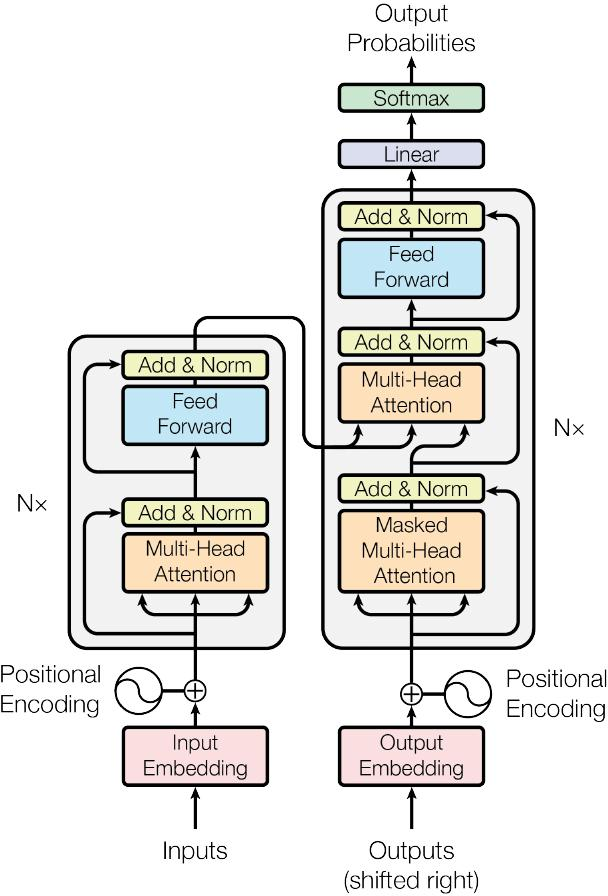

In [144]:
# View one of the images
import os
from IPython.display import Image
display(Image('./Images/figure-3-1.jpg'))

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

In [146]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_chroma import Chroma
from langchain_core.documents import Document

def create_multi_vector_retriever(
    docstore, vectorstore,
    text_summaries, texts, 
    table_summaries, tables, 
    image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """
    id_key = "doc_id"
    
    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key=id_key,
    )
    
    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))
    
    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)
    return retriever

In [147]:
# The vectorstore to use to index the summaries and their embeddings
# The storage layer for the parent documents
from langchain.storage import InMemoryStore
store = InMemoryStore()
id_key = "doc_id"
chroma_db = Chroma(
    collection_name="mm_rag",
    embedding_function=embedding,
    collection_metadata={"hnsw:space": "cosine"},
)

In [148]:
# Create retriever
retriever_multi_vector = create_multi_vector_retriever(
    store,  chroma_db,
    text_summaries, texts,
    table_summaries, tables,
    image_summaries, imgs_base64,
)

In [149]:
# Summary of a text chunk element
text_summaries[0]

'The paper "Attention Is All You Need" by Ashish Vaswani and colleagues from Google Brain and Google Research introduces the Transformer, a novel neural network architecture for sequence transduction tasks. Unlike traditional models that rely on recurrent or convolutional networks, the Transformer uses only attention mechanisms, eliminating the need for recurrence and convolutions. This approach enhances parallelization and reduces training time. The Transformer achieved superior performance on machine translation tasks, with a BLEU score of 28.4 on the WMT 2014 English-to-German task and 41.8 on the English-to-French task, surpassing previous models. The authors also demonstrated the model\'s effectiveness in English constituency parsing. The paper credits equal contributions from the authors, with specific roles detailed for each contributor. The work was presented at the 31st Conference on Neural Information Processing Systems (NIPS 2017).'

In [150]:
#Summary of a table element
table_summaries[0]

'The table compares different neural network layer types based on their complexity per layer, sequential operations, and maximum path length. Self-Attention layers have a complexity of O(n - d), with O(1) for both sequential operations and maximum path length. Recurrent layers have a complexity of O(n - d), with O(n) for both sequential operations and maximum path length. Convolutional layers have a complexity of O(k-n-d), with O(1) for sequential operations and O(log(n)) for maximum path length. Restricted Self-Attention layers have a complexity of O(r-n-d), with O(1) for sequential operations and O(n/r) for maximum path length.'

In [151]:
from IPython.display import HTML, display, Image
from PIL import Image
import base64
from io import BytesIO

def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Decode the base64 string
    img_data = base64.b64decode(img_base64)
    # Create a BytesIO object
    img_buffer = BytesIO(img_data)
    # Open the image using PIL
    img = Image.open(img_buffer)
    display(img)

In [152]:
# Check retrieval
query = "Tell me about the encoder?"
docs = retriever_multi_vector.invoke(query, limit=5)
len(docs)

4

In [164]:
# Testing on retrieval
query = "Tell me about the encoder?"
suffix_for_images = " Include any pie charts, graphs, or tables or images"
docs = retriever_multi_vector.invoke(query + suffix_for_images)

In [165]:
docs

['N dyoast de Rh de dy Parop ets Game | deny dev). base | 6 5122048. 8 64 64 O01 O1 100K] 492.258 65 1 512 512 5.29 24.9 A) 4 128 128 5.00 25.5 16 32 32 491 258 32 16 16 5.01 25.4 16 5.16 251 58 (8) 32 5.01 254 60 2 611 23.7 36 4 5.19 253 50 8 488 255 80 ©) 256 32 32 5.75 245 28 1024 128 128 4.66 26.0 168 1024 5.12 254 53 4096 475 262 90 0.0 5.77 24.6 0.2 495 25.5 @) 0.0 467 253 0.2 5.47 25.7 (E) positional embedding instead of sinusoids 4.92 25.7',
 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEB


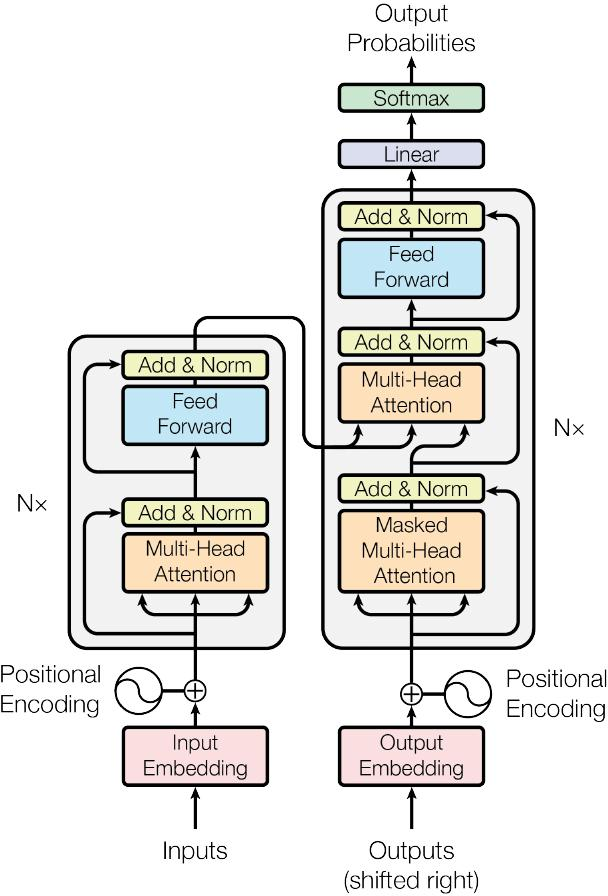

In [166]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))


plt_img_base64(docs[1])